# Introductory SDK Example

A typical approach to use DynaCrop API is to create a polygon, representing an agricultural field, and obtain desired information for it. Say we've already [authenticated](authentication.html).

In this example, we want to obtain the last available state of the field with regard to the [NDVI index](https://docs.dynacrop.space/docs/#/products?id=ndvi-normalized-difference-vegetation-index).

First, we set up necessary imports for our example:

In [1]:
from matplotlib import pyplot as plt
import geopandas as gpd

from dynacrop import Polygon, Observation, Layer

## Polygon setup
To create a [Polygon](https://docs.dynacrop.space/docs/#/api?id=interface-for-polygon-management), we need a **valid polygon geometry** in the Well-Known-Text (WKT) format in **WGS 84** coordinate system. It can look like this:

In [2]:
test_field_wkt = "POLYGON ((15.381691455695547 49.303972332109694, 15.38159608797287 49.3027037636056, 15.382111072758565 49.30221871416425, 15.380394458334196 49.30134810027714, 15.379993915339584 49.30103716295746, 15.379078387559279 49.2998680211984, 15.376846789658885 49.299420257525554, 15.376045703342243 49.29903468018158, 15.375301837593726 49.30257939242007, 15.381691455695547 49.303972332109694))"

It is also possible to prepare it by loading a spatial file with `geopandas`. We then take any valid polygon geometry and convert it to WKT.

In [ ]:
fields_gdf = gpd.read_file('test_field.shp')
test_field_geometry = fields_gdf.loc[0].geometry

test_field_wkt = test_field_geometry.to_wkt()


Now we simply call create on a Polygon class and fill in necessary parameters. Such, we create a polygon object that is automatically paired with a database of your api key and added among your fields.

In [3]:
field1 = Polygon.create(
    test_field_wkt,
    label="My test field",
    max_mean_cloud_cover=0.3,
    smi_enabled=False
)

field1



**DynaCrop API is asynchronous**. This means that our SDK request does not need to wait for the server to respond. The script is terminated right after it processes itself, i.e. sucessfully sends requests to the API. This is advantageous if we want to send many requests or the processing-heavy ones and do not want to wait.

On the other hand, we may intend to continue processing further in our srcipt. Here, it is most likely undesired if the request (`Polygon.create` in our case) had not finished processing on the API side.

Therefore, the SDK has a method `block_till_completed` to wait for the request to finish on the API side. We call this method right after firing the request:

In [4]:
field1 = Polygon.create(
    test_field_wkt,
    label="My test field",
    max_mean_cloud_cover=0.3,
    smi_enabled=False
)

field1.block_till_completed()

# Now we wait :)

# The status is garuanteed to be finished: completed or error
f"{field1.label} is {field1.status}. Field id = {field1.id}"

'My test field is completed. Field id = 62509'

## Create a processing request and obtain results
Once our polygon is **completed**, we can establish a [processing request](https://docs.dynacrop.space/docs/#/services). We chose [Observation](https://docs.dynacrop.space/docs/#/services?id=observation) for this example since it is the easiest to grasp. The programming principle is quite similar to that behind `Polygon`. Observation gives us the actual state of the field to the latest available date.

Observation, as any other processing request, has mandatory parameters. These are:

- our previously created polygon (`field1`)
- a [layer](https://docs.dynacrop.space/docs/#/products?id=available-indicesproducts), where we must use built-in enumeration `Layer` for layers. In most editors, this even gives us hinting.
- dates from and to

Again, we can opt to wait until the processing request is finished on the API side.

In [5]:
observation1 = Observation.create(
    polygon=field1, 
    layer=Layer.NMDI, 
    date_from="2020-06-01", 
    date_to="2020-08-30"
)

observation1.block_till_completed()

print(observation1, f"\nStatus: {observation1.status}")

<dynacrop.Observation 1332218> 
Status: completed


If the Observation has finished sucessfully, we can obtain results, which, again, is quite simple.

The results can be saved in multiple formats. To stay within Python environment, we can decide between representations of: 

- *raster* - multidimensional `NumPy array` 
- *vector* - Geopandas `GeoDataFrame`

(1, 55, 49)


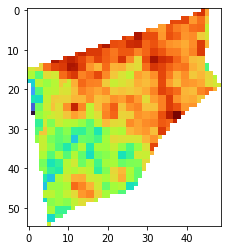

In [6]:
observation_raster = observation1.as_array()
print(observation_raster.shape)

# When displaying, we need to slice the first dimension
plt.imshow(observation_raster[0], cmap='turbo')

In [7]:
observation_vector = observation1.as_geodataframe()

# The GeoDataFrame composes of particular pixels or dissolved parts 
# depending on the Digital Number (DN), i.e. the pixel value.
observation_vector

geometry      fid        DN
0    POLYGON ((15.38156 49.30397, 15.38169 49.30397...    out.0  0.628972
1    POLYGON ((15.38114 49.30388, 15.38128 49.30388...    out.1  0.638143
2    POLYGON ((15.38142 49.30397, 15.38156 49.30397...    out.2  0.642138
3    POLYGON ((15.38072 49.30379, 15.38100 49.30379...    out.3  0.639286
4    POLYGON ((15.38100 49.30379, 15.38128 49.30379...    out.4  0.630317
..                                                 ...      ...       ...
406  POLYGON ((15.37655 49.29948, 15.37683 49.29948...  out.408  0.603687
407  POLYGON ((15.37683 49.29948, 15.37697 49.29948...  out.409  0.614668
408  POLYGON ((15.37627 49.29930, 15.37655 49.29930...  out.410  0.606111
409  POLYGON ((15.37600 49.29930, 15.37627 49.29930...  out.412  0.597313
410  POLYGON ((15.37600 49.29912, 15.37614 49.29912...  out.413  0.617317

[411 rows x 3 columns]

## Simple external visualization

Additionally, DynaCrop API enables us to create a simple visualization of the result in a web browser using *tiles*. The result will be shown in an original [DynaCrop color scheme](https://docs.dynacrop.space/docs/#/colors), depending on the used Layer (NDVI in our case).

In [8]:
# This opens a default web browser with Leaflet interface and 
# zooms to the result over an ortophoto map.
observation1.preview()

## Store results
We can store results in various formats using `observation1.save*` methods. Here we are going to store the result as raster, in the GeoTIFF format. We just need to specify the path.

In [ ]:
observation1.save_tiff('./observation_test_field.tiff')